## Klasifikasi Gambar Kartu

In [14]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

### Load Data & Cleaning

In [3]:
df = pd.read_csv('cards.csv')

# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8155 entries, 0 to 8154
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class index  8155 non-null   int64 
 1   filepaths    8155 non-null   object
 2   labels       8155 non-null   object
 3   card type    8155 non-null   object
 4   data set     8155 non-null   object
dtypes: int64(1), object(4)
memory usage: 318.7+ KB


In [4]:
# Head
df.head(6)

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train
5,0,train/ace of clubs/006.jpg,ace of clubs,ace,train


### Preprocessing

In [5]:
# Pisahkan dataframe untuk setiap set data
train_df = df[df['data set'] == 'train']
valid_df = df[df['data set'] == 'valid']
test_df = df[df['data set'] == 'test']

In [6]:
train_df.head(6)

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train
5,0,train/ace of clubs/006.jpg,ace of clubs,ace,train


In [7]:
# Definisikan ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_test_datagen = ImageDataGenerator(rescale=1./255)

# Tentukan parameter gambar
IMG_SIZE = (200, 200)
BATCH_SIZE = 32

# Buat generator data dari dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_generator = validation_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_generator = validation_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 7624 validated image filenames belonging to 53 classes.
Found 265 validated image filenames belonging to 53 classes.
Found 265 validated image filenames belonging to 53 classes.


C:\Users\LENOVO\anaconda3\envs\klasifikasi_kartu\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [8]:
# Muat model dasar MobileNetV2
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Bekukan bobot model dasar agar tidak ikut terlatih
base_model.trainable = False

# Tambahkan lapisan klasifikasi kustom di atasnya
x = base_model.output
x = GlobalAveragePooling2D()(x)
output_layer = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Gabungkan menjadi model akhir
model = Model(inputs=base_model.input, outputs=output_layer)

# Tampilkan arsitektur model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 100, 100, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 100, 100, 32  128         ['Conv1[0][0]']                  
                                )                                                             

### Komplikasi Model

In [9]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Latih Model

In [10]:
EPOCHS = 10

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)


Epoch 1/10
239/239 [==============================] - 560s 2s/step - loss: 2.9101 - accuracy: 0.2162 - val_loss: 2.2451 - val_accuracy: 0.3132
Epoch 2/10
239/239 [==============================] - 377s 2s/step - loss: 2.1719 - accuracy: 0.3759 - val_loss: 1.9921 - val_accuracy: 0.3962
Epoch 3/10
239/239 [==============================] - 366s 2s/step - loss: 1.9232 - accuracy: 0.4467 - val_loss: 1.8807 - val_accuracy: 0.4151
Epoch 4/10
239/239 [==============================] - 342s 1s/step - loss: 1.7602 - accuracy: 0.4923 - val_loss: 1.8663 - val_accuracy: 0.4528
Epoch 5/10
239/239 [==============================] - 332s 1s/step - loss: 1.6610 - accuracy: 0.5150 - val_loss: 1.7928 - val_accuracy: 0.4755
Epoch 6/10
239/239 [==============================] - 335s 1s/step - loss: 1.5916 - accuracy: 0.5283 - val_loss: 1.7084 - val_accuracy: 0.4717
Epoch 7/10
239/239 [==============================] - 329s 1s/step - loss: 1.5102 - accuracy: 0.5539 - val_loss: 1.7144 - val_accuracy: 0.4792

### Evaluasi Model

In [11]:
loss, accuracy = model.evaluate(test_generator)

print(f"\nAkurasi pada Data Tes: {accuracy * 100:.2f}%")

9/9 [==============================] - 10s 1s/step - loss: 1.8019 - accuracy: 0.4679

Akurasi pada Data Tes: 46.79%


## Visualisasi Model

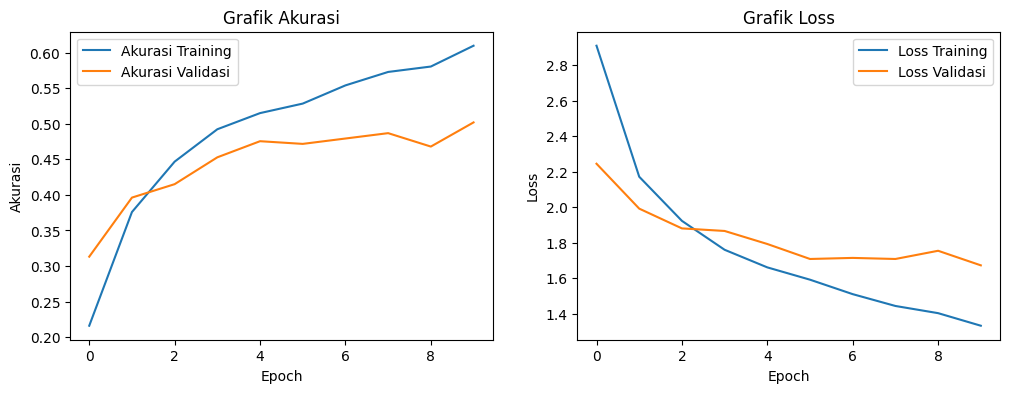

In [12]:
plt.figure(figsize=(12, 4))

# Plot grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Grafik Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot grafik Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Grafik Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Membuat Model jauh lebih akurat

In [13]:
## FINE TUNING LAPISAN MODEL DAN ADJUST LEARNIG RATE
base_model.trainable = True

# Kita akan membekukan 100 lapisan pertama dan melatih sisanya
fine_tune_at = 100 

# Bekukan semua lapisan sebelum lapisan `fine_tune_at`
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Kompilasi ulang model dengan learning rate yang lebih rendah
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Learning rate lebih rendah
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan kembali arsitektur model untuk melihat perubahan
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 100, 100, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 100, 100, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [15]:
## OPTIMISASI MODEL DENGAN MENAMBAHKAN CALLBACK

# Callback untuk mengurangi learning rate jika tidak ada peningkatan
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001
)

# Callback untuk menghentikan training jika tidak ada peningkatan loss validasi
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    verbose=1, 
    restore_best_weights=True # Mengembalikan bobot terbaik saat training berhenti
)

In [16]:
## MELATIH ULANG DENGAN KONFIGURASI BARU

initial_epochs = 10 # Epochs yang sudah dijalankan sebelumnya
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Melanjutkan dari epoch terakhir
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stop]
)

Epoch 10/30
239/239 [==============================] - 475s 2s/step - loss: 1.6588 - accuracy: 0.5115 - val_loss: 1.6635 - val_accuracy: 0.5547 - lr: 1.0000e-04
Epoch 11/30
239/239 [==============================] - 524s 2s/step - loss: 1.0742 - accuracy: 0.6684 - val_loss: 1.4603 - val_accuracy: 0.5811 - lr: 1.0000e-04
Epoch 12/30
239/239 [==============================] - 515s 2s/step - loss: 0.8265 - accuracy: 0.7463 - val_loss: 0.9970 - val_accuracy: 0.7170 - lr: 1.0000e-04
Epoch 13/30
239/239 [==============================] - 537s 2s/step - loss: 0.6719 - accuracy: 0.7922 - val_loss: 0.7990 - val_accuracy: 0.7321 - lr: 1.0000e-04
Epoch 14/30
239/239 [==============================] - 457s 2s/step - loss: 0.5322 - accuracy: 0.8362 - val_loss: 0.8079 - val_accuracy: 0.7283 - lr: 1.0000e-04
Epoch 15/30
239/239 [==============================] - 310s 1s/step - loss: 0.4529 - accuracy: 0.8644 - val_loss: 0.8302 - val_accuracy: 0.7472 - lr: 1.0000e-04
Epoch 16/30
239/239 [=============

In [17]:
loss, accuracy = model.evaluate(test_generator)
print(f"\nAkurasi Baru pada Data Tes: {accuracy * 100:.2f}%")

9/9 [==============================] - 9s 908ms/step - loss: 0.6042 - accuracy: 0.8189

Akurasi Baru pada Data Tes: 81.89%


In [18]:
# Gabungkan history training awal dengan history fine-tuning
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

### Visualisasi

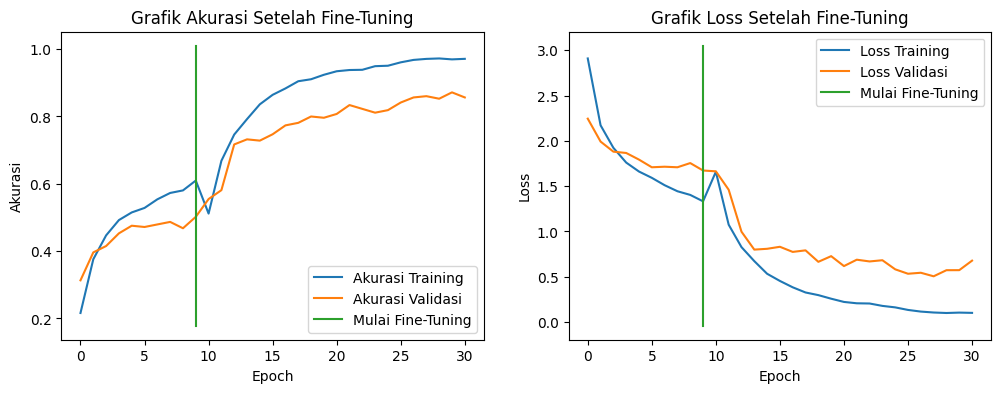

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Akurasi Training')
plt.plot(val_acc, label='Akurasi Validasi')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Mulai Fine-Tuning')
plt.title('Grafik Akurasi Setelah Fine-Tuning')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss Training')
plt.plot(val_loss, label='Loss Validasi')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Mulai Fine-Tuning')
plt.title('Grafik Loss Setelah Fine-Tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()